# Definition

## Project Overview

## Problem Statement

## Metrics

# Analysis

## Data Exploration

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
import pixiedust
from IPython.display import Markdown as md
from scipy.sparse import csr_matrix

%matplotlib inline

import plot_helper

Pixiedust database opened successfully


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The data set for this project was downloaded from Kaggle at  
[8anu climbing logbook](https://www.kaggle.com/dcohen21/8anu-climbing-logbook)

In [3]:
# Connect to db
conn = sqlite3.connect('data/8anu.sqlite')

# Read data into pandas
sql = ('SELECT a.id, a.country AS crag_country, a.crag_id, a.crag, a.sector_id, a.sector, a.name AS route, '
       'a.grade_id, g.fra_routes AS grade, a.year, a.date, a.method_id, m.shorthand AS method, a.notes, a.raw_notes, a.rating, '
       'a.user_id, u.country AS user_country, u.city AS user_city, u.sex, u.height, u.weight, u.birth AS birthdate, u.started AS started_climbing '
       'FROM ('
           'SELECT * '
           'FROM ascent '
           'WHERE crag=\'Frankenjura\' AND climb_type=0'
       ') AS a '
       'LEFT OUTER JOIN grade AS g ON a.grade_id=g.id '
       'LEFT OUTER JOIN method AS m ON a.method_id=m.id '
       'LEFT OUTER JOIN user AS u ON a.user_id=u.id '
       )
df = pd.read_sql_query(sql, conn)

# Close db connection
conn.close()

In [4]:
# Export to .csv for submitting Project Proposal to Udacity
#df.to_csv('data/8anu_franken.csv', sep=';')

In [5]:
# Export to .xlsx
# Create a Pandas Excel writer using XlsxWriter as the engine.
#writer = pd.ExcelWriter('data/8anu_franken.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
#df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
#writer.save()

### General information about the data set

In [6]:
## Get a list of all columns
df.columns

Index(['id', 'crag_country', 'crag_id', 'crag', 'sector_id', 'sector', 'route',
       'grade_id', 'grade', 'year', 'date', 'method_id', 'method', 'notes',
       'raw_notes', 'rating', 'user_id', 'user_country', 'user_city', 'sex',
       'height', 'weight', 'birthdate', 'started_climbing'],
      dtype='object')

In [7]:
df.head(5)

,id,crag_country,crag_id,crag,sector_id,sector,route,grade_id,grade,year,...,raw_notes,rating,user_id,user_country,user_city,sex,height,weight,birthdate,started_climbing
0,582,DEU,16600,Frankenjura,126,Grüne Hölle,Isolation,46,6c+,2000,...,0,0,39,NLD,Eindhoven,0.0,178.0,78.0,1972-10-16,1996.0
1,805,DEU,16600,Frankenjura,111,Marientaler Wände,Kraftfeld,59,7c+,1999,...,0,0,32,SWE,Gothenburg,0.0,174.0,0.0,1976-06-15,1996.0
2,902,DEU,16600,Frankenjura,1309,Obere Schlossbergwände,Ursus,49,7a,2000,...,0,0,49,SWE,GÖTEBORG,0.0,0.0,0.0,None,1990.0
3,903,DEU,16600,Frankenjura,0,,Don't know name,46,6c+,2000,...,0,0,49,SWE,GÖTEBORG,0.0,0.0,0.0,None,1990.0
4,935,DEU,16600,Frankenjura,422,Richard Wagner Fels,Fight Gravity,53,7b,1999,...,0,0,3,SWE,Umeå,0.0,180.0,78.0,1973-09-09,1995.0


In [8]:
records_count = df.shape[0]
ratings_count = df[ df['rating'] == 0].shape[0]


f'There are {records_count:,} data entries in our dataset.'
f'{ratings_count:,} out of these contain a rating. That is approx. {ratings_count / records_count * 100:.2f}%'

'There are 114,589 data entries in our dataset.'

'60,303 out of these contain a rating. That is approx. 52.63%'

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114589 entries, 0 to 114588
Data columns (total 24 columns):
id                  114589 non-null int64
crag_country        114589 non-null object
crag_id             114589 non-null int64
crag                114589 non-null object
sector_id           114589 non-null int64
sector              114589 non-null object
route               114589 non-null object
grade_id            114589 non-null int64
grade               114589 non-null object
year                114589 non-null int64
date                114589 non-null int64
method_id           114589 non-null int64
method              114589 non-null object
notes               114589 non-null object
raw_notes           114589 non-null int64
rating              114589 non-null int64
user_id             114589 non-null int64
user_country        114587 non-null object
user_city           114587 non-null object
sex                 114587 non-null float64
height              114587 non-null fl

| <p align='left'>`Column` | <p align='left'>Description | <p align='center'> Datatype | <p align='center'> Use | 
|:------|:------|:------:|:------:| 
| <p align='left'>`crag_country` | <p align='left'>3-letter country code of the country where the crag is located. | <p align='center'> categorical | <p align='center'> no | 
| <p align='left'>`crag_id` | <p align='left'>Unique id for identifying each crag. | <p align='center'> int | <p align='center'> no | 
| <p align='left'>`crag` | <p align='left'>Name of the crag | <p align='center'> text | <p align='center'> no | 
| <p align='left'>`sector_id` | <p align='left'>Unique id for identifying each sector. | <p align='center'> int | <p align='center'> yes | 
| <p align='left'>`sector` | <p align='left'>Name of the sector. A sector is a specific area within a crag. | <p align='center'> text | <p align='center'> yes | 
| <p align='left'>`route` | <p align='left'>Name of the route the climber has climbed. | <p align='center'> text | <p align='center'> yes | 
| <p align='left'>`grade_id` | <p align='left'>Unique id for identifying each climbing grade. | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`grade` | <p align='left'>Climbing grade given to that route as per the French grading system | <p align='center'> categorical | <p align='center'> statistics | 
| <p align='left'>`year` | <p align='left'>Year the route was climbed | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`date` | <p align='left'>Date the route was climbed. The date format is number of seconds since 1970-01-01. | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`method_id` | <p align='left'>Unique id for identifying each type of ascent. | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`method` | <p align='left'>The type of ascent the climber made on that route. | <p align='center'> categorical | <p align='center'> statistics | 
| <p align='left'>`notes` | <p align='left'>Additional information the climber provided for this climb, e.g. Soft graded, i.e. fairly easy climb for the given grade | <p align='center'> categorical | <p align='center'> statistics | 
| <p align='left'>`raw_notes` | <p align='left'>Encoding of different notes and combination of notes | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`rating` | <p align='left'>Rating given to the climb by this climber. This is our target attribute. | <p align='center'> int | <p align='center'> target | 
| <p align='left'>`user_id` | <p align='left'>Unique id for this climber. | <p align='center'> int | <p align='center'> yes | 
| <p align='left'>`user_country` | <p align='left'>3-letter country code of the country where this climber is from. | <p align='center'> categorical | <p align='center'> statistics | 
| <p align='left'>`user_city` | <p align='left'>City where this climber is from | <p align='center'> text | <p align='center'> statistics | 
| <p align='left'>`sex` | <p align='left'>The climber's sex. 0 indicates male, 1 indicates female. | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`height` | <p align='left'>The climber's height in cm | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`weight` | <p align='left'>The climber's weight in kg | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`birthdate` | <p align='left'>The climber's date of birth | <p align='center'> date | <p align='center'> statistics | 
| <p align='left'>`started_climbing` | <p align='left'>The year the climber started climbing. | <p align='center'> int | <p align='center'> statistics | ![image.png](attachment:image.png)

In the table above the column `Use` indicated how we plan to use the given column.
- `target` - this is a target attribute.
- `yes` - this column will be used during exploration and analysis.
- `no` - not planned to use that column during analysis and exploration.
- `statistics` - this column will not be used for analysis but may be interesting later on to do user statistics etc.

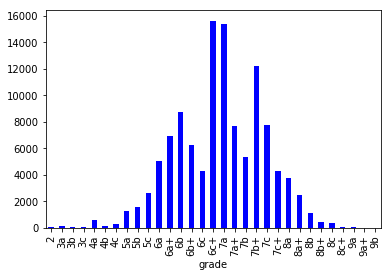

In [10]:
df.groupby('grade').count()['id'].plot(kind='bar', color='b')


<img src="climbing_grades_comparison.png" alt="Grade comparison table" width="500" align="left" />


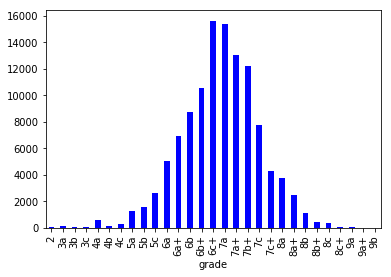

In [11]:
df_grade_adjusted = df.copy()
df_grade_adjusted.loc[df_grade_adjusted['grade'] == '6c'] = '6b+'
df_grade_adjusted.loc[df_grade_adjusted['grade'] == '7b'] = '7a+'
df_grade_adjusted.groupby('grade').count()['id'].plot(kind='bar', color='b')

Drop unnecessary columns for analysis.

In [12]:
df = df.drop(columns=['crag_country',
                      'crag_id',
                      'crag',
                      'grade_id',
                      'grade',
                      'year',
                      'date',
                      'method_id',
                      'method',
                      'notes',
                      'raw_notes',
                      'user_country',
                      'user_city',
                      'sex',
                      'height',
                      'weight',
                      'birthdate',
                      'started_climbing'])

Split train and test set to avoid bias

In [13]:
from sklearn.model_selection import train_test_split

# y = df.pop('rating')
X = df

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

### Missing values

Let us take a look if we have **missing values** or **zero values**.

Number of missing values per column:

In [14]:
X_train.isnull().sum()
# y_train.isnull().sum()

id           0
sector_id    0
sector       0
route        0
rating       0
user_id      0
dtype: int64

Number of zero values per column:

In [15]:
(X_train == 0).sum()
# (y_train == 0).sum()

id               0
sector_id    12301
sector           0
route            0
rating       48291
user_id          0
dtype: int64

### Unique values

A naive estimate on the number of unique sectors and routes within these sectors. Submitted by a number of distinct users.

In [16]:
X_train[['sector_id', 'route', 'user_id']].nunique()

sector_id      350
route        12471
user_id       3292
dtype: int64

Why do we call the above estimate _naive_? 

According to (climb-europe.com)[http://www.climb-europe.com/RockClimbingGermany/RockClimbingFrankenjura.html] _there are approximately 1,000 crags spread out in a beautiful forest terrain_ (Note that _crags_ in the above quote is the same as _sectors_ in our dataset.) This seems fine since in our dataset there are 351 different sectors noted.

In the article it continues to claim that _Frankenjura boasts in excess of 10,000 routes._ Now this is where we should get a little suspicious. In only 350 sectors our dataset apparently contains already more than 12,000 routes - which is well above the 10,000 mentioned in the article.

Lets dig deeper here.


What are the records where `sector_id` is 0?  
We take a look at a number of samples.

In [17]:
X_train[X_train['sector_id'] == 0].head(10)

,id,sector_id,sector,route,rating,user_id
22531,1366698,0,,Gelegenheit macht Diebe,3,9660
72926,3458547,0,Gumpenwand,Zollfrei,0,16195
94967,4322459,0,,Doppelpack,2,9493
101666,4487349,0,Hintere Reibertsbergwand,Schnecke,0,20095
75222,3511955,0,,Glaspatronenmatch,3,9255
32469,1921878,0,,Rayando el sol,0,11628
71909,3442794,0,Vogelherdwand,Rechts außen,0,10264
45119,2463848,0,,Wo Ist Dein Paradies?,3,3166
54809,2869412,0,,Ninja Turtle,0,18285
62462,3070359,0,Mosenberger Block,Görglesweg,0,37450


## Exploratory Visualization

### Missing values

Lets look at the **Missing** or **Zero values** per column.

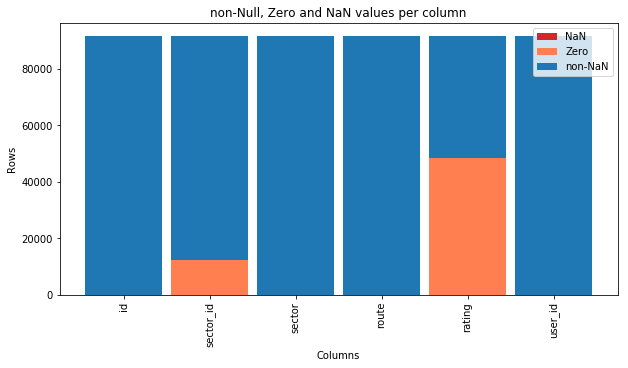

In [18]:
plot_helper.missing_values_overview(X_train)

In our data set `0` is in indicator for missing values, except for `sex` where `0` indicates `male` (and `1` for `female`).

From the graph above we can conclude that we have missing data in `sector_id`, `raw_notes`, `rating`, `height`, `weight`, `birth`, `started_climbing`.

Since `sector_id` and `rating` are important for our analysis, we have to consider what to do about those missing values during Data Preparation later on.

## Analysis of our target variable `rating`

What are the unique values of our target variable?

In [19]:
y_train = X_train['rating']
y_train.unique()

array([0, 1, 3, 2])

And how is their distribution?


In [20]:
percentages = round(y_train.value_counts().sort_index() / y_train.count() * 100, 1)
percentages

0    52.7
1    11.0
2    18.8
3    17.5
Name: rating, dtype: float64

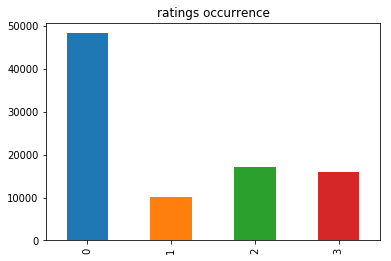

In [21]:
y_train.value_counts().sort_index().plot(
    kind='bar', title='ratings occurrence', xticks=percentages)

In [22]:
y_train[y_train != 0].describe()

count    43380.000000
mean         2.137091
std          0.764778
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: rating, dtype: float64

Out of those climbs, that were rated, the average is 2.14.

What is the percentage of users that rated at least one climb?

In [23]:
(X_train.groupby('user_id')['rating'].sum() == 0).value_counts()

False    2242
True     1050
Name: rating, dtype: int64

This means that approx. 2/3 of users have rated at least one item.

How many ratings are there per user?

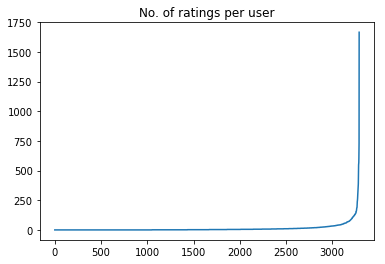

In [24]:
ratings_per_user = X_train.groupby('user_id')['rating'].apply(lambda x: x[x != 0].count())
ratings_per_user.sort_values().plot(
    kind='line', title='No. of ratings per user', use_index=False)

From the above plot we can see that there must be one or several outliers with a large number of ratings (around 1600). Let's apply the logarithm on the y-axis.

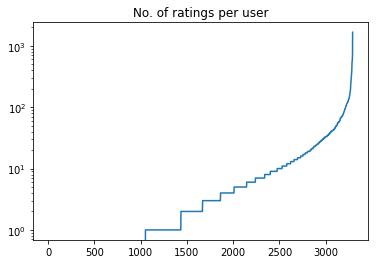

In [25]:
ratings_per_user.sort_values().plot(
    kind='line', title='No. of ratings per user', use_index=False, logy=True)

Now, this has more information. We can see that approx. 30% of users gave no rating at all. And more than 90% of users gave less than 200 ratings.

Let's look at the percentiles information in detail to confirm this.

In [26]:
ratings_per_user.describe(percentiles=[.25, 0.33, .50, .75, .90, .95, .99])

count    3292.000000
mean       13.177400
std        49.680102
min         0.000000
25%         0.000000
33%         1.000000
50%         2.000000
75%         9.000000
90%        29.000000
95%        53.000000
99%       153.270000
max      1665.000000
Name: rating, dtype: float64

## Algorithms and Techniques

## Benchmark

# Methodology

## Data Preprocessing

Remove records from dataset where `sector_id == 0`

In [27]:

X_train = X_train[X_train['sector_id'] != 0]

In [28]:
# TODO
# Consolidate sectors, e.g. sector_id: 839, 12382

### Consolidate route names, remove duplicates

Since our data set does not provide a unique id for routes, we can only go by the name to identify a route. Unfortunately, there are many versions of route names as well as spelling mistakes. In order to arrive at a unique list of routes, we need to do some cleaning up.  

The following example illustrates that.

In [29]:
X_train[X_train['route'].str.startswith('Adr')].drop_duplicates(subset=['route'])['route']

8849      Adrspach weg
100234    Adrspach Weg
Name: route, dtype: object

Let's start by converting all route names to lowercase and removing special characters.

In [30]:
def string_cleaning(df, columns):
    '''Remove special characters and convert to lowercase. Apply to all columns as specified'''

    df[columns] = df[columns].applymap(lambda s: s.lower())

    # Need to use Series because regular replace() cannot handle RegEx
    for c in columns:
        df[c] = df[c].str.replace('[^A-Za-z\s]+', '') # TODO keep numbers??
        
        # Remove rows with empty values as they are unusable
        df = df[df[c] != '']

    return df

X_train = string_cleaning(X_train, ['route'])

Next, let's define a couple of functions that will help us to clean up duplicate route names within sectors.

In [31]:
# http://www.coli.uni-saarland.de/courses/LT1/2011/slides/Python-Levenshtein.html
from Levenshtein import jaro_winkler

def create_jaro_winkler(keys, prefix_weight=None):
    '''Calculates Jaro-Winkler-Distance among all items of `keys` and returns calculation results as a matrix'''

    # TODO  is there a more pythonic way of calculating this matrix?
    
    jaro_winkler_matrix = np.ones((len(keys), len(keys)))

    i = 0
    while i <= len(keys) - 1:
        j = 0
        while j <= len(keys) - 1:
            if i != j:
                jaro_winkler_matrix[i][j] = jaro_winkler(
                    keys[i], keys[j]) if prefix_weight is None else jaro_winkler(keys[i], keys[j], prefix_weight)
            j += 1
        i += 1

    return jaro_winkler_matrix

def remove_overlap(d):
    '''Resolve 'paths' within the dictionary, e.g. 
     { A : B, B : C }  ->  { A : C, B : C }
     Returns cleaned dictionary'''

    set_keys = set(d.keys())
    set_values = set(d.values())
    set_intersect = set_keys.intersection(set_values)

    for v in set_intersect:
        new_target = d[v]

        filtered_dict = {key: new_target for (
            key, value) in d.items() if value == v}
        filtered_dict

        for i, j in d.items():
            if i in filtered_dict.keys():
                d[i] = filtered_dict[i]

    return d

In [32]:
def get_routes_per_sector(df, sector_id):
    '''Returns a series with route names as labels and count of route name occurrences as values'''

    df_one_sector = df[df['sector_id'] == sector_id]
    return df_one_sector['route'].value_counts()

def clean_route_names_sector(df, sector_id, threshold=0.9, prefix_weight=1/100, debug=False):
    '''Replaces route name within given `sector_id` with the most similar matching name that has the most occurrences.'''

    routes_per_sector = get_routes_per_sector(df, sector_id)
    keys = routes_per_sector.keys()
    values = routes_per_sector.values

    # Create Jaro-Winkler-Matrix and fill diagonal with zeros, 
    # otherwise max value will always be 1.0 (as diagonal is always 1.0)
    jaro_winkler_matrix = create_jaro_winkler(keys, prefix_weight)
    np.fill_diagonal(jaro_winkler_matrix, 0)

    # empty nested dictionary, for replacements of similar route names
    replacements = {'route': {}}

    # find max count of values above threshold
    indices_above_threshold = np.transpose(
        np.nonzero(jaro_winkler_matrix >= threshold))

    first_values = [t[0] for t in indices_above_threshold]
    unique_first_values = np.unique(first_values)

    for u in unique_first_values:
        tuples_list = [t for t in indices_above_threshold if t[0] == u]
        counts_list = [values[t2[1]] for t2 in tuples_list]
        val_max = max(counts_list)
        index_max = counts_list.index(max(counts_list))
        keys[tuples_list[index_max][1]]

        if values[u] < values[tuples_list[index_max][1]]:
            replacements['route'][keys[u]] = keys[tuples_list[index_max][1]]
            if debug:
                print(
                    f'Replacement: {keys[u]}({values[u]}) : {keys[tuples_list[index_max][1]]}({values[tuples_list[index_max][1]]}) ')        

    # Resolve overlaps in replacements
    replacements['route'] = remove_overlap(replacements['route'])
        
    # Replace all found similar route names
    df.loc[df['sector_id'] == sector_id] = df.replace(
        to_replace=replacements)

    return df

def clean_route_names(df):
    '''Cleans up duplicate route names within sectors.'''
    
    for sid in df['sector_id'].unique():
        df = clean_route_names_sector(df, sid)
    return df   

In [33]:
X_train = clean_route_names(X_train)

In [34]:
# jaro_winkler('adrschpach weg', 'adrspach weg', 1/100)
X_train[X_train['route'].str.startswith('adr')].drop_duplicates()

,id,sector_id,sector,route,rating,user_id
8849,653580,839,Leupoldsteiner wand,adrspach weg,2,493
72720,3455818,839,Leupoldsteiner wand,adrspach weg,2,35939
100234,4442345,839,Leupoldsteiner Wand,adrspach weg,2,63837
108437,4784525,839,Leupoldsteiner Wand,adrspach weg,0,49724
83951,3876112,839,Leupoldsteiner Wand,adrspach weg,0,50842
18543,1210005,839,Leupoldsteiner Wand,adrspach weg,2,13622
57253,2950046,839,Leupoldsteiner Wand,adrspach weg,0,5184
103874,4660072,839,Leupoldsteiner wand,adrspach weg,0,65237
43374,2423630,839,Leupoldsteiner Wand,adrspach weg,0,42457
108529,4785752,839,Leupoldsteiner Wand,adrspach weg,0,64806


### Get list of unique routes

Extract all the individual routes. We also keep `sector_id` here, because there can be routes with the same name that lie in different sectors.

In [35]:
X_train_routes = X_train[['sector_id', 'route']].drop_duplicates(['sector_id', 'route'])
a = X_train_routes.shape[0]
md(f'So, our new count for routes is **{a}**, which is a lot less than what our naive count was.')

So, our new count for routes is **6754**, which is a lot less than what our naive count was.

Reset the index of our consolidated list of routes.

In [36]:
X_train_routes.index.name = 'route_id'
X_train_routes.reset_index(inplace=True)
# X_train_routes = X_train_routes.drop(columns=['index'])
X_train_routes.head(5)

,route_id,sector_id,route
0,85331,10081,victoria
1,74439,360,via donatella
2,12478,2745,viecherei
3,100249,111,geisterbahn
4,42745,525,fun


### Get list of unique users

In [37]:
X_train_users = X_train['user_id'].drop_duplicates()
X_train_users.reset_index(inplace=True, drop=True)
X_train_users.head(5)

0    11314
1    32996
2    20095
3    63659
4    35674
Name: user_id, dtype: int64

### Get list of ratings

In [38]:
X_train_ratings = pd.merge(X_train_routes, X_train, on=['sector_id', 'route'])[['route_id', 'sector', 'route', 'user_id', 'rating']]
X_train_ratings['sector_route'] = X_train_ratings['sector'] + '_' + X_train_ratings['route']
X_train_ratings.head(5)

,route_id,sector,route,user_id,rating,sector_route
0,85331,Rammstein,victoria,11314,0,Rammstein_victoria
1,85331,Rammstein,victoria,228,0,Rammstein_victoria
2,85331,Rammstein,victoria,18214,2,Rammstein_victoria
3,85331,Rammstein,victoria,16968,0,Rammstein_victoria
4,85331,Rammstein,victoria,22780,0,Rammstein_victoria


## Implementation

In [39]:

user_route_ratings = pd.pivot_table(X_train_ratings, index='user_id', columns= 'sector_route', values='rating')

print('dataset dimensions: ', user_route_ratings.shape, '\n\nSubset example:')
user_route_ratings.iloc[:6, :10]

dataset dimensions:  (3149, 7566) 

Subset example:


sector_route,AMPHITHEATER_angel dust,AMPHITHEATER_die dunkle seite,Affentheater_affenhitze,Affentheater_affenkante,Affentheater_affenplatte,Affentheater_affensex,Affentheater_affentanz,Affentheater_bonobo,Affentheater_chimpanzee,Affentheater_decision
user_id,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
user_id = 39
# user_id = 35939
X_test[X_test['user_id'] == user_id]
# user_route_ratings.loc[user_id]

,id,sector_id,sector,route,rating,user_id
0,582,126,Grüne Hölle,Isolation,0,39


In [41]:
def get_most_rated_routes(user_route_ratings, max_number_of_routes):
    # 1- Count
    user_route_ratings = user_route_ratings.append(user_route_ratings.count(), ignore_index=True)
    # 2- sort
    user_route_ratings_sorted = user_route_ratings.sort_values(len(user_route_ratings)-1, axis=1, ascending=False)
    user_route_ratings_sorted = user_route_ratings_sorted.drop(user_route_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_routes = user_route_ratings_sorted.iloc[:, :max_number_of_routes]
    return most_rated_routes

def get_users_who_rate_the_most(most_rated_routes, max_number_of_routes):
    # Get most voting users
    # 1- Count
    most_rated_routes['counts'] = pd.Series(most_rated_routes.count(axis=1))
    # 2- Sort
    most_rated_routes_users = most_rated_routes.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_routes_users_selection = most_rated_routes_users.iloc[:max_number_of_routes, :]
    most_rated_routes_users_selection = most_rated_routes_users_selection.drop(['counts'], axis=1)
    
    return most_rated_routes_users_selection

def sort_by_rating_density(user_route_ratings, n_routes, n_users):
    most_rated_routes = get_most_rated_routes(user_route_ratings, n_routes)
    most_rated_routes = get_users_who_rate_the_most(most_rated_routes, n_users)
    return most_rated_routes

In [42]:
n_routes = 30
n_users = 18
most_rated_routes_users_selection = sort_by_rating_density(user_route_ratings, n_routes, n_users)

print('dataset dimensions: ', most_rated_routes_users_selection.shape)
most_rated_routes_users_selection.head()

dataset dimensions:  (18, 30)


sector_route,Weißenstein_dampfhammer,Obere Schlossbergwände_dala,Grüne Hölle_isolation,Obere Schlossbergwände_liebe ohne chance,Marientaler Wände_saftfeld,Richard Wagner Fels_fight gravity,Grüne Hölle_solid rock,Heldwand_heldbru,Diebesloch_blutspur,Marientaler Wände_opa falkenstein,...,Diebesloch_beavis butthead,Krottenseer Turm_westwand,Obere Schlossbergwände_dezentraler energiepfad,Andeltodrom_kauabouga,Soranger Wand_second chance,Grüne Hölle_range rover,Bärenschlucht_herkules,Soranger Wand_massaker,Wolfsberger Grotte_orang utan,Weißenstein_baggi ned
341,3.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0,3.0,2.0,...,3.0,3.0,3.0,1.0,1.0,NaN,NaN,2.0,3.0,2.0
1603,3.0,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,0.0,...,3.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,3.0,0.0
1501,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN
1258,3.0,3.0,2.0,3.0,2.0,3.0,2.0,NaN,2.0,NaN,...,3.0,NaN,2.0,1.0,1.0,0.0,3.0,0.0,NaN,3.0
2086,3.0,1.0,2.0,3.0,2.0,3.0,NaN,1.5,2.0,0.0,...,3.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,3.0,0.0


In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def draw_routes_heatmap(most_rated_routes_users_selection, axis_labels=True):

    # Reverse to match the order of the printed dataframe
    #most_rated_routes_users_selection = most_rated_routes_users_selection.iloc[::-1]

    fig = plt.figure(figsize=(15, 4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_routes_users_selection,
                        interpolation='nearest', vmin=0, vmax=3, aspect='auto')

    if axis_labels:
        ax.set_yticks(
            np.arange(most_rated_routes_users_selection.shape[0]), minor=False)
        ax.set_xticks(
            np.arange(most_rated_routes_users_selection.shape[1]), minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_routes_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(
            most_rated_routes_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['3 stars', '2 stars', '1 stars', '0 stars'])

    plt.show()

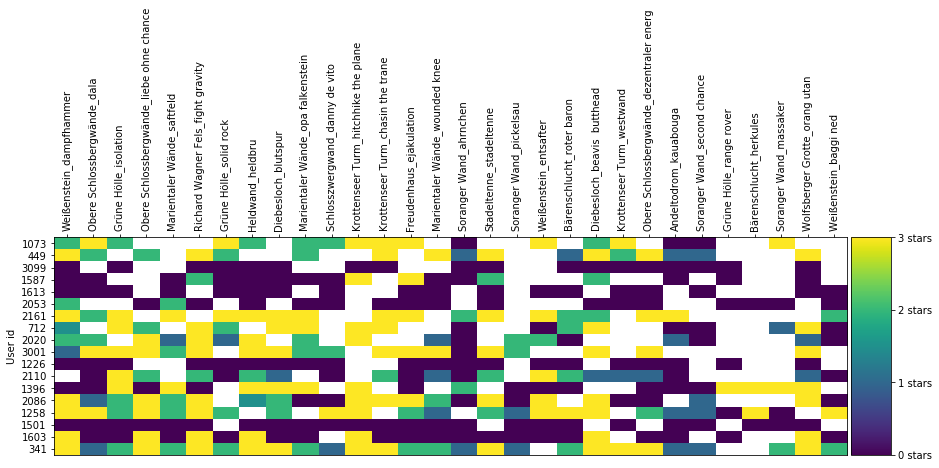

In [44]:
draw_routes_heatmap(most_rated_routes_users_selection)

In [45]:
# user_route_ratings_str = user_route_ratings.copy()
# user_route_ratings_str.columns = user_route_ratings_str.columns.astype(str)
# sparse_ratings = csr_matrix(pd.SparseDataFrame(user_route_ratings_str).to_coo())

sparse_ratings = csr_matrix(pd.SparseDataFrame(user_route_ratings).to_coo())

### Clustering

In [46]:
from sklearn.cluster import KMeans

# TODO find number of clusters

# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

In [47]:
len(predictions)
sparse_ratings.shape
user_route_ratings.shape
# predictions
# user_route_ratings

3149

(3149, 7566)

(3149, 7566)

In [48]:
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

{0: 2775,
 1: 1,
 2: 1,
 3: 1,
 4: 150,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 19,
 17: 1,
 18: 1,
 19: 189}

In [49]:
def draw_route_clusters(clustered, max_users, max_routes):
    c = 1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_routes routes per cluster.
        # You can change these values to see more users & routes per cluster
        d = clustered[clustered.group == cluster_id].drop(
            ['user_id', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]

        d = sort_by_rating_density(d, max_routes, max_users)

        d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_routes]
        n_users_in_plot = d.shape[0]

        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster),
                  '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15, 4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]), minor=False)
            ax.set_xticks(np.arange(d.shape[1]), minor=False)

            ax.set_xticklabels(labels, minor=False)

            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=3, aspect='auto')

            ax.set_xlabel('routes')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(
                ['3 stars', '2 stars', '1 stars', '0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off',
                            top='off', left='off', labelbottom='off', labelleft='off')
            # print('cluster # {} \n(Showing at most {} users and {} routes)'.format(cluster_id, max_users, max_routes))

            plt.show()

            # Let's only show 5 clusters
            # Remove the next three lines if you want to see all the clusters
            # Contribution welcomed: Pythonic way of achieving this
            # c = c+1
            # if c > 6:
            #    break

In [50]:
max_users = 70
max_routes = 50

# is this line messing up my user_id?
clustered = pd.concat([user_route_ratings.reset_index(),
                       pd.DataFrame({'group': predictions})], axis=1)
# clustered = clustered.rename_axis('user_id')
# clustered = pd.concat([user_route_ratings,
#                        pd.DataFrame({'group': predictions})], axis=1)
# clustered[clustered['group'].isnull()]
# clustered['user_id'] = clustered.index
clustered.head(3)
clustered = clustered.set_index('user_id')
clustered.head(3)
clustered['user_id'] = clustered.index
clustered.head(3)

,user_id,AMPHITHEATER_angel dust,AMPHITHEATER_die dunkle seite,Affentheater_affenhitze,Affentheater_affenkante,Affentheater_affenplatte,Affentheater_affensex,Affentheater_affentanz,Affentheater_bonobo,Affentheater_chimpanzee,...,zimmerbergwände_starfighter kandidatenweg,zwergenschloss_born to be alive,zwergenschloss_ich habs wollen wissen,zwergenschloss_linie,zwergenschloss_magnesiapower,zwergenschloss_panic room,zwergenschloss_starlight express,zwergenschloss_uschi mach keinen quatsch,zwergenschloss_zentrifuge,group
0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


,AMPHITHEATER_angel dust,AMPHITHEATER_die dunkle seite,Affentheater_affenhitze,Affentheater_affenkante,Affentheater_affenplatte,Affentheater_affensex,Affentheater_affentanz,Affentheater_bonobo,Affentheater_chimpanzee,Affentheater_decision,...,zimmerbergwände_starfighter kandidatenweg,zwergenschloss_born to be alive,zwergenschloss_ich habs wollen wissen,zwergenschloss_linie,zwergenschloss_magnesiapower,zwergenschloss_panic room,zwergenschloss_starlight express,zwergenschloss_uschi mach keinen quatsch,zwergenschloss_zentrifuge,group
user_id,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


,AMPHITHEATER_angel dust,AMPHITHEATER_die dunkle seite,Affentheater_affenhitze,Affentheater_affenkante,Affentheater_affenplatte,Affentheater_affensex,Affentheater_affentanz,Affentheater_bonobo,Affentheater_chimpanzee,Affentheater_decision,...,zwergenschloss_born to be alive,zwergenschloss_ich habs wollen wissen,zwergenschloss_linie,zwergenschloss_magnesiapower,zwergenschloss_panic room,zwergenschloss_starlight express,zwergenschloss_uschi mach keinen quatsch,zwergenschloss_zentrifuge,group,user_id
user_id,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15


In [51]:
clustered[clustered['group'].isnull()]

,AMPHITHEATER_angel dust,AMPHITHEATER_die dunkle seite,Affentheater_affenhitze,Affentheater_affenkante,Affentheater_affenplatte,Affentheater_affensex,Affentheater_affentanz,Affentheater_bonobo,Affentheater_chimpanzee,Affentheater_decision,...,zwergenschloss_born to be alive,zwergenschloss_ich habs wollen wissen,zwergenschloss_linie,zwergenschloss_magnesiapower,zwergenschloss_panic room,zwergenschloss_starlight express,zwergenschloss_uschi mach keinen quatsch,zwergenschloss_zentrifuge,group,user_id
user_id,,,,,,,,,,,,,,,,,,,,,


In [52]:
# Get a random cluster number with cluster size >= threshold
threshold = 20
group_counts = clustered['group'].value_counts()
group_counts = group_counts[group_counts >= threshold]
group_counts
random_cluster_number = group_counts.sample(1).index[0]

0     2775
19     189
4      150
Name: group, dtype: int64

In [53]:
# clustered.tail(20)

/Users/dominik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  if sys.path[0] == '':
/Users/dominik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  del sys.path[0]
/Users/dominik/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cluster # 0
# of users in cluster: 2775. # of users in plot: 70


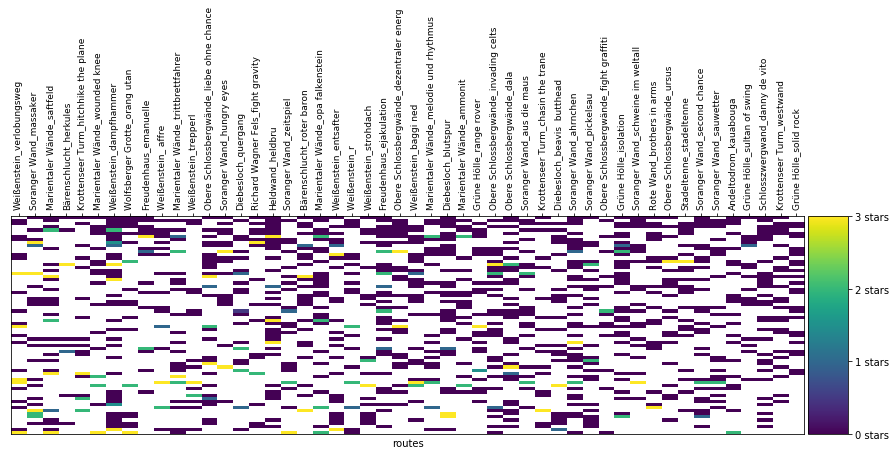

cluster # 4
# of users in cluster: 150. # of users in plot: 70


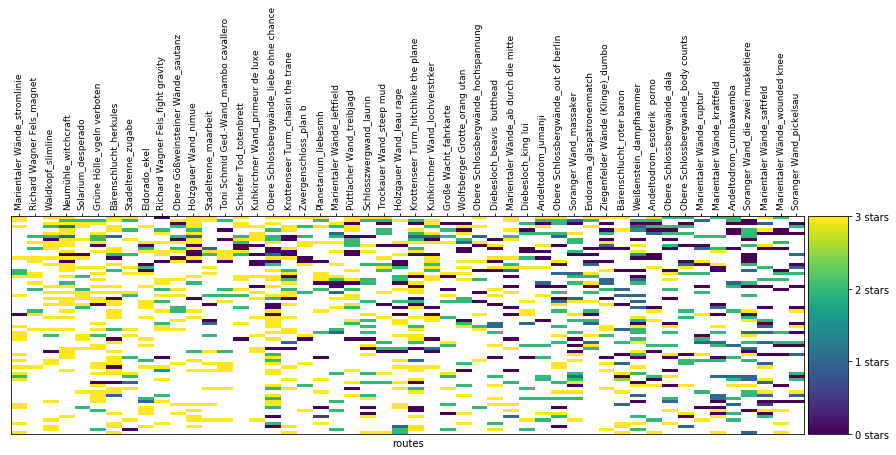

cluster # 16
# of users in cluster: 19. # of users in plot: 19


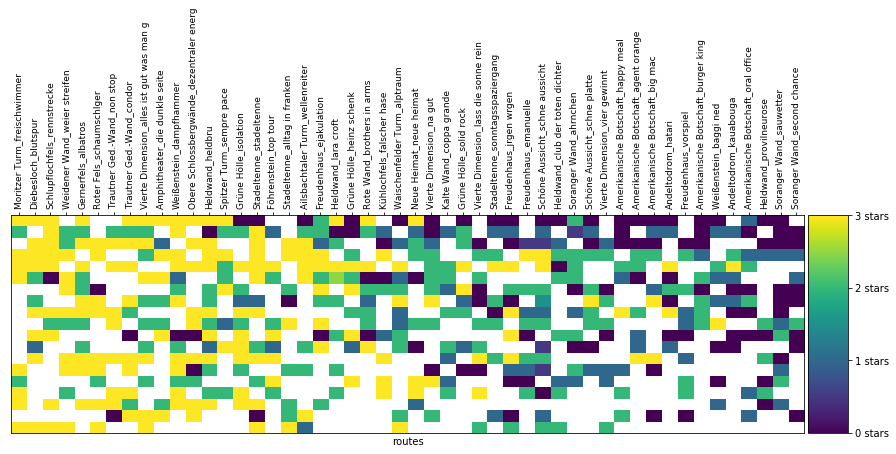

cluster # 19
# of users in cluster: 189. # of users in plot: 70


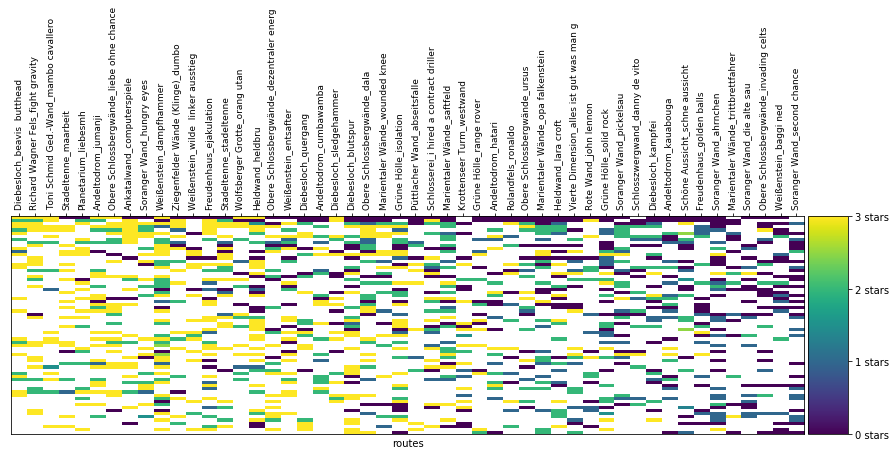

In [54]:
draw_route_clusters(clustered, max_users, max_routes)


## Prediction
Let's pick a cluster and a specific user and see what useful things this clustering will allow us to do.

Let's first pick a cluster:

In [55]:
def get_cluster(clustered, cluster_number):
    
#     cluster = clustered[clustered.group == cluster_number].drop(['user_id', 'group'], axis=1)
    cluster = clustered[clustered.group == cluster_number].drop(['group'], axis=1)
    cluster = cluster.set_index('user_id')
    cluster = cluster.rename_axis('user_id')
    
    return cluster

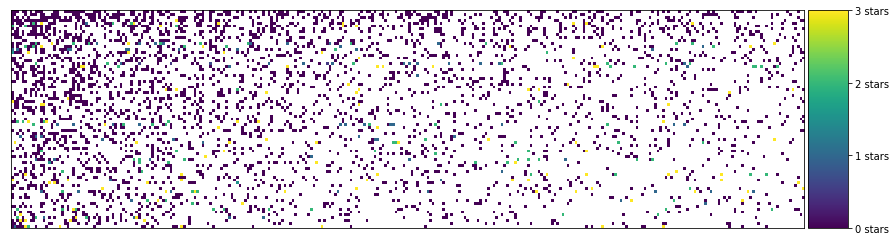

In [56]:
# TODO: Pick a cluster ID from the clusters above
cluster_number = random_cluster_number

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_routes = 300
cluster = get_cluster(clustered, cluster_number)

cluster = sort_by_rating_density(cluster, n_routes, n_users)
draw_routes_heatmap(cluster, axis_labels=False)

# set cluster back to original (because sort_by_rating_density() modifies cluster)
cluster = get_cluster(clustered, cluster_number) 

In [57]:
# cluster.fillna('').head()

In [58]:
route_name = 'Wolfsberger Grotte_panda'

cluster[route_name].mean()

0.7777777777777778

In [59]:
# cluster.mean().sort_values()

In [60]:
def cluster_membership(clustered, user_id):
    '''given a clustered dataframe, returns the cluster number that user_id is a member of'''
    
    return clustered[clustered['user_id'] == user_id]['group'].iloc[0]

In [61]:
%%latex

Weighted Rating (WR) = $(\frac{v}{v + m} \cdot R) + (\frac{m}{v + m} \cdot C)$

<IPython.core.display.Latex object>

where
- *v* is the number of ratings for that route
- *m* is the minimum ratings required to be listed in the chart
- *R* is the average rating of the route
- *C* is the mean vote across the whole report

In [62]:
def weighted_rating(x):
    v = x['rating_count']
    R = x['rating_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [63]:
# Count ratings and calculate mean rating per route
def calc_rating_avg_count(x):
    d = {}
    d['rating_count'] = x['rating'].count()
    d['rating_average'] = x['rating'].mean()
    return pd.Series(d, index=['rating_average', 'rating_count'])

# X_train_ratings.groupby('route_id').apply(calc_rating_avg_count)

# X_train_ratings.groupby()

In [64]:
def cluster_avg_count(cluster):
    '''Given a cluster, calculate each route's avg rating and count of ratings. '''
    
    df = pd.DataFrame()
    df['sector_route'] = cluster.columns

    for i, row in df.iterrows():
        rating_average = cluster[row['sector_route']].mean()
        rating_count = cluster[row['sector_route']].count()
        df.at[i,'rating_average'] = rating_average
        df.at[i,'rating_count'] = rating_count
        
    return df

# cluster_avg_count(cluster).head(3)

In [65]:
def top_n_routes_cluster(cluster, n=0):
    '''Calculate weighted rating of all routes. Return top-n routes. If n==0, return all routes'''

    percentile = 0.85

    # get count and mean of ratings per route for this cluster
    df_counts_average = cluster_avg_count(cluster)

    C = df_counts_average['rating_average'].mean()
    m = df_counts_average['rating_count'].quantile(percentile)

    # Filter for routes that have ratings above threshold m
    qualified = df_counts_average[(df_counts_average['rating_count'] >= m) & (
        df_counts_average['rating_count'].notnull()) & (df_counts_average['rating_average'].notnull())]

    # calculate weighted rating for each route
    qualified['wr'] = qualified.apply(lambda x: (x['rating_count']/(x['rating_count']+m)
                                                 * x['rating_average']) + (m/(m+x['rating_count']) * C), axis=1)

    # Sort by rating
    qualified = qualified.sort_values(
        'wr', ascending=False) if n == 0 else qualified.sort_values('wr', ascending=False).head(n)

    # Return the top n routes
    return qualified


def top_n_routes_user(clustered, user_id, n):
    '''Return top n routes of a user'''

    # get cluster number
    cluster_number = cluster_membership(clustered, user_id)

    # retrieve cluster by cluster number
    cluster = get_cluster(clustered, cluster_number)

    # retrieve top routes by cluster
    df_top_routes_cluster = top_n_routes_cluster(cluster)

    # subtract user's already climbed and rated routes from result
    df_top_routes_cluster_without_user = df_top_routes_cluster.drop(
        df_top_routes_cluster[df_top_routes_cluster['sector_route'].isin(cluster.loc[user_id].dropna().index)].index)

    return df_top_routes_cluster_without_user.head(n)

In [66]:
user_id = 32
# user_id = 35939
clustered[clustered['user_id'] == user_id]

,AMPHITHEATER_angel dust,AMPHITHEATER_die dunkle seite,Affentheater_affenhitze,Affentheater_affenkante,Affentheater_affenplatte,Affentheater_affensex,Affentheater_affentanz,Affentheater_bonobo,Affentheater_chimpanzee,Affentheater_decision,...,zwergenschloss_born to be alive,zwergenschloss_ich habs wollen wissen,zwergenschloss_linie,zwergenschloss_magnesiapower,zwergenschloss_panic room,zwergenschloss_starlight express,zwergenschloss_uschi mach keinen quatsch,zwergenschloss_zentrifuge,group,user_id
user_id,,,,,,,,,,,,,,,,,,,,,
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,32


In [67]:
user_id = 32
# user_id = 35939

cluster_number = cluster_membership(clustered, user_id)
f'cluster_number: {cluster_number}'
cluster = get_cluster(clustered, cluster_number)
cluster

top_n = top_n_routes_cluster(cluster)
top_n.shape
# top_n.head(5)
# top_n['sector_route'].isin(cluster.loc[18].dropna().index)
# cluster.index
top_n_without_user = top_n.drop(
    top_n[top_n['sector_route'].isin(cluster.loc[user_id].dropna().index)].index)
# top_n_without_user.head(5)
top_n_without_user.shape

'cluster_number: 0'

,AMPHITHEATER_angel dust,AMPHITHEATER_die dunkle seite,Affentheater_affenhitze,Affentheater_affenkante,Affentheater_affenplatte,Affentheater_affensex,Affentheater_affentanz,Affentheater_bonobo,Affentheater_chimpanzee,Affentheater_decision,...,zimmerbergwände_knig ludwig superstar,zimmerbergwände_starfighter kandidatenweg,zwergenschloss_born to be alive,zwergenschloss_ich habs wollen wissen,zwergenschloss_linie,zwergenschloss_magnesiapower,zwergenschloss_panic room,zwergenschloss_starlight express,zwergenschloss_uschi mach keinen quatsch,zwergenschloss_zentrifuge
user_id,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


limit_output extension: Maximum message size of 10000 exceeded with 46866 characters

In [68]:
cluster = get_cluster(clustered, random_cluster_number)
cluster.tail(10)

,AMPHITHEATER_angel dust,AMPHITHEATER_die dunkle seite,Affentheater_affenhitze,Affentheater_affenkante,Affentheater_affenplatte,Affentheater_affensex,Affentheater_affentanz,Affentheater_bonobo,Affentheater_chimpanzee,Affentheater_decision,...,zimmerbergwände_knig ludwig superstar,zimmerbergwände_starfighter kandidatenweg,zwergenschloss_born to be alive,zwergenschloss_ich habs wollen wissen,zwergenschloss_linie,zwergenschloss_magnesiapower,zwergenschloss_panic room,zwergenschloss_starlight express,zwergenschloss_uschi mach keinen quatsch,zwergenschloss_zentrifuge
user_id,,,,,,,,,,,,,,,,,,,,,
66562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
f'Top 10 Cluster'
top_n_routes_cluster(cluster, 25)

'Top 10 Cluster'

/Users/dominik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,sector_route,rating_average,rating_count,wr
626,Bärenschlucht_herkules,1.592593,108.0,1.520534
4779,Roter Fels_schaumschlger,1.550000,60.0,1.432088
1123,Eldorado_ekel,1.493827,81.0,1.408786
2446,Hintere Stadelhofener Wände_woodcocks in time,1.750000,16.0,1.349249
4494,Richard Wagner Fels_fight gravity,1.374233,163.0,1.335567
4146,Obere Schlossbergwände_monstermagnet,2.000000,8.0,1.273874
3065,Krottenseer Turm_chasin the trane,1.308824,136.0,1.266542
2445,Hintere Stadelhofener Wände_strahlentod,1.555556,18.0,1.245461
4098,Obere Gößweinsteiner Wände_sautanz,1.338983,59.0,1.244507
7150,Zwergenschloss_plan b,1.406250,32.0,1.234550


In [71]:
# %%pixie_debugger
# user_id = 557

users = [3, 32, 493, 35939, 63837]
for u in users:
    f'user_id: {u} is member of cluster number: {cluster_membership(clustered, u)}'
    top_n_routes_user(clustered, u, 5)
    f''

f'Top 10 User'
# top_n_routes_user(clustered, user_id, 25)

'user_id: 3 is member of cluster number: 0'

/Users/dominik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,sector_route,rating_average,rating_count,wr
626,Bärenschlucht_herkules,1.592593,108.0,1.520534
4779,Roter Fels_schaumschlger,1.550000,60.0,1.432088
1123,Eldorado_ekel,1.493827,81.0,1.408786
2446,Hintere Stadelhofener Wände_woodcocks in time,1.750000,16.0,1.349249
4146,Obere Schlossbergwände_monstermagnet,2.000000,8.0,1.273874


''

'user_id: 32 is member of cluster number: 0'

,sector_route,rating_average,rating_count,wr
4779,Roter Fels_schaumschlger,1.550000,60.0,1.432088
1123,Eldorado_ekel,1.493827,81.0,1.408786
2446,Hintere Stadelhofener Wände_woodcocks in time,1.750000,16.0,1.349249
4494,Richard Wagner Fels_fight gravity,1.374233,163.0,1.335567
4146,Obere Schlossbergwände_monstermagnet,2.000000,8.0,1.273874


''

'user_id: 493 is member of cluster number: 16'

,sector_route,rating_average,rating_count,wr
4777,Roter Fels_ringe der idioten,3.000000,5.0,2.500934
3143,Kühlochfels_ab geht die post,2.857143,7.0,2.500726
39,Algersdorfer Wand_brennpunkt,2.777778,9.0,2.500594
454,Bleisteine_offenbarung,2.750000,8.0,2.450654
284,Bandstein_herbstmanver,2.833333,6.0,2.438317


''

'user_id: 35939 is member of cluster number: 0'

,sector_route,rating_average,rating_count,wr
626,Bärenschlucht_herkules,1.592593,108.0,1.520534
4779,Roter Fels_schaumschlger,1.550000,60.0,1.432088
1123,Eldorado_ekel,1.493827,81.0,1.408786
2446,Hintere Stadelhofener Wände_woodcocks in time,1.750000,16.0,1.349249
4494,Richard Wagner Fels_fight gravity,1.374233,163.0,1.335567


''

'user_id: 63837 is member of cluster number: 0'

,sector_route,rating_average,rating_count,wr
626,Bärenschlucht_herkules,1.592593,108.0,1.520534
4779,Roter Fels_schaumschlger,1.550000,60.0,1.432088
1123,Eldorado_ekel,1.493827,81.0,1.408786
2446,Hintere Stadelhofener Wände_woodcocks in time,1.750000,16.0,1.349249
4494,Richard Wagner Fels_fight gravity,1.374233,163.0,1.335567


''

'Top 10 User'

## Refinement

# Results

## Model Evaluation and Validation

## Justification

# Conclusion

## Free-Form Visualization

## Reflection

## Improvement